<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORT DELLE LIBRERIE E CARICAMENTO DEL DATASET**


In [52]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat, Mask
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
import pycocotools
from pycocotools import mask
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
TRAIN_DIR = '/content/drive/MyDrive/trainingset'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\trainingset'#
TEST_DIR = '/content/drive/MyDrive/testset'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\testset'#
TRAIN_LABELS = '/content/drive/MyDrive/train.json'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\train.json'#
TEST_LABELS =  '/content/drive/MyDrive/test.json'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\test.json'
IM_WIDTH = 700
IM_HEIGHT = 700
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [100]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [101]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [102]:
def formatLabels(labels):
  bbox = []
  seg = []
  cls = []
  i = 0
  for label in labels:
    seg.append(decodeSegmentationField(label['segmentation']))
    b = label['bbox']
    box = [b[0],b[1],b[0]+b[2], b[1]+b[3]]
    if(box[2]-box[0] <= 0):
      box[2]+=1
    if(box[3]-box[1] <= 0):
      box[3]+=1
    bbox.append(box)
    i+=1
    cls.append(label['category_id']+1)
  return  {
      'boxes': torchvision.tv_tensors.BoundingBoxes(data=np.array(bbox),format = BoundingBoxFormat.XYXY, canvas_size=(IM_WIDTH, IM_HEIGHT)),
      'labels': torch.tensor(cls, dtype = torch.int64),
      'image_id': label['image_id'],
      'area': torch.tensor(label['area'], dtype=torch.float64),
      'iscrowd': torch.tensor(label['iscrowd'], dtype=torch.uint8),
      'masks': Mask(seg)
  }

In [103]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = {} #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories[c['name']] = c['id']+1 #incrementiamo di uno per distinguere la background class

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    #tra = torchvision.transforms.Resize((700,700))
    return (image,formatLabels(label))
  def __len__(self):
    return len(os.listdir(self.img_dir))


In [104]:
#caricamento dei dataset di train e di test
trainset = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

#**LOSS FUNCTIONS**

In [ ]:
class CustomLossFunction(nn.Module):
  def __init__(self, cls_loss, bb_loss, seg_loss, cls_weight, bb_weight, seg_weight):
    super(CustomLossFunction, self).__init__()
    self.cls_loss = cls_loss
    self.bb_loss = bb_loss
    self.seg_loss = seg_loss
    self.cls_weight = cls_weight
    self.bb_weight = bb_weight
    self.seg_weight = seg_weight
  def forward(self,predictions, targets):
    prediction = predictions[0]
    formatted_targets = formatLabels(targets)
    #loss di classificazione
    #scores di classificazione: uno per ogni oggetto predetto
    targets_cls = formatted_targets['labels']
    pred_cls = prediction['scores']
    loss_cls = self.cls_loss(pred_cls,targets_cls)
    #loss di bbox
    targets_bbox = formatted_targets['boxes']
    pred_bbox = prediction['boxes']
    loss_bbox = self.bb_loss(pred_bbox,targets_bbox)
    #loss per le maschere: sigmoide su tutti i pixel e poi cross entropy
    targets_masks = formatted_targets['masks']
    pred_masks = prediction['masks']
    loss_masks = self.seg_loss(pred_masks,targets_masks)

    return self.cls_weight*loss_cls + self.bb_weight*loss_bbox + self.seg_weight*loss_masks

#**TEST DI UN MODELLO PREADDESTRATO: MASK R-CNN**

##***CARICAMENTO DEL MODELLO***

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 219MB/s]


In [ ]:
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=5)

# Replace the mask predictor
#model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=4)

In [105]:
def targetsToDevice(targets, device):
  return [{
      'boxes': target['boxes'].to(device),
      'labels': target['labels'].to(device),
      'image_id': target['image_id'],
      'area': target['area'].to(device),
      'iscrowd':target['boxes'].to(device),
      'masks': target['masks'].to(device)
  } for target in targets]

In [106]:
torch.cuda.empty_cache()
model = torch.load('/content/drive/MyDrive/maskrcnn_14ep')
#model.to(device)

##***MODEL TRAINING***

In [107]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
model.train()
model.to(device)
#predictions = model([trainset[3][0]], [formatLabels(trainset[3][1])])
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 15
trains = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True,collate_fn= collate_fn)
total_step = len(trains)

num_epochs = 6

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,optimizer):
    for batch_idx, (images, targets) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        images = [image.to(device) for image in images]
        targets = targetsToDevice(targets,device)
        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        #backward pass
        losses.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        if (batch_idx+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, losses))

        train_losses.append(losses)
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [ ]:
for epoch in range(3,num_epochs+1):
  train(epoch=epoch, model = model, optimizer = optimizer)
  #torch.save(model, '/content/drive/MyDrive/maskrcnn_{}ep'.format(epoch))

##***MODEL EVALUATION***

In [108]:
#GENERAZIONE DEL FILE JSON IN FORMATO COCO
#costruisco il dataloader per il test set
model.eval()
batch_size = 1
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

results = []
j = -1
for idx, (images, targets) in enumerate(testloader):

  prediction = model([image.to(device) for image in images])[0]
  classes = prediction['labels'].cpu().numpy()
  scores = prediction['scores'].cpu().detach().numpy()
  boxes = prediction['boxes'].view(-1,4).cpu().detach().numpy()
  masks = prediction['masks'].view(-1,IM_HEIGHT,IM_WIDTH).cpu().detach().numpy()
  for i in range(masks.shape[0]):
    image_id = targets[0]['image_id']
    bbox = boxes[i]
    bbox = [round(float(x)*10)/10 for x in bbox]
    rle = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
    rle['counts'] = rle['counts'].decode('ascii')
    j+=1
    results.append({
                'image_id': int(image_id),
                'category_id': int(classes[i])-1,
                'bbox': bbox,
                'segm': rle,
                'score': float(scores[i]),
                'area': (bbox[2]-bbox[0])*(bbox[3]-bbox[1]),
                'height': IM_HEIGHT,
                'width': IM_WIDTH,
                'id':j
            })

  torch.cuda.empty_cache()
with open('/content/pred.json', 'w') as fp:
    json.dump(results, fp)


In [109]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
test = '/content/drive/MyDrive/test.json'
pred = '/content/pred.json'
gt = COCO(test)
detections = gt.loadRes(pred)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.31s)
creating index...
index created!


In [110]:
annType = 'bbox'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.59s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [111]:
annType = 'segm'
cocoEval = COCOeval(gt, detections, annType)
#cocoEval.params.imgIds  = range(400,852)
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=5.99s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

#***CODICI DI PROVA***

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def drawBoxes(image, boxes):
    image = image.to('cpu')
    boxes = boxes.to('cpu')
    plt.clf()
    im = torchvision.transforms.ToPILImage()(image)
    # Create figure and axes
    fig, ax = plt.subplots()
    ax.imshow(im)
    for box in boxes:
        box = box.detach().numpy()
        x = box[0]
        y = box[1]
        w = box[2]-box[0]
        h = box[3]-box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

<Figure size 640x480 with 0 Axes>

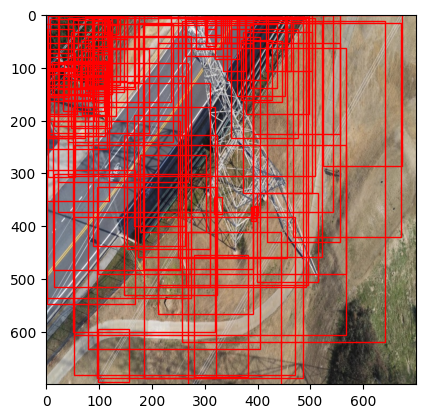

In [ ]:
drawBoxes(test[1][0], prediction[0]['boxes'])

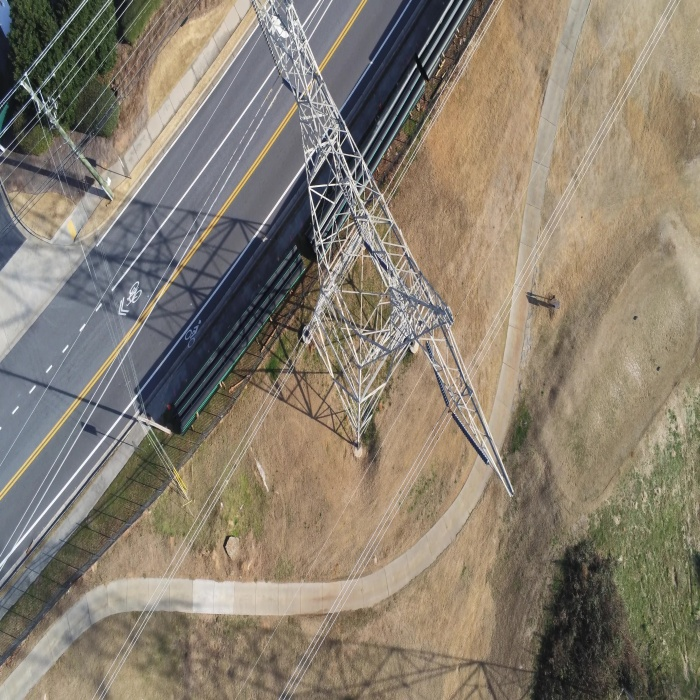

In [ ]:
torchvision.transforms.ToPILImage()(test[1][0])

In [ ]:
import array
m = test[0][1]['masks'][0]
rle_encoded = mask.encode(np.asfortranarray(m[:, :, np.newaxis].numpy().astype(np.uint8)))[0]
byte_array = array.array('B', rle_encoded['counts'])
byte_array

AttributeError: ignored

In [ ]:
import json
f = json.load(open('/content/drive/MyDrive/test.json'))
m = f['annotations'][0]['segmentation']
m

[[699.6943612774451,
  532.1024617431804,
  699.8177083333334,
  554.1666666666666,
  647.9540918163673,
  373.3643823464183,
  592.6116516966068,
  179.50210689731648,
  541.5885416666666,
  0.0,
  546.5475299401198,
  0.1940563317808827,
  580.4952594810379,
  119.73275670880462,
  631.2531187624751,
  296.7121312929696]]

In [91]:
model.eval()
prediction = model([test[0][0].to(device)])
prediction[0]['boxes']

tensor([[535.4915,   0.0000, 699.1820, 552.2519],
        [315.3330,  13.9122, 385.3933, 696.2737],
        [313.5010,  36.2878, 361.5191, 469.5155],
        [347.0924,   0.0000, 421.4338, 700.0000],
        [359.3104,  52.2930, 399.8593, 658.0847],
        [338.3316,   7.6885, 494.3379, 696.1543],
        [362.0298,  51.5762, 692.8303, 574.6003],
        [309.0237,  76.6982, 388.4190, 394.8252]], device='cuda:0',
       grad_fn=<StackBackward0>)

In [92]:
test[0][1]['boxes']

BoundingBoxes([[541.,   0., 699., 554.],
               [324.,   0., 400., 699.],
               [309.,   0., 374., 699.]], dtype=torch.float64, format=BoundingBoxFormat.XYXY, canvas_size=(700, 700))